# **Geometry matrix creation for fast visible cameras on tokamak GOLEM**
This notebook computes the grid and geometry matrix for the tomography using two fast visible cameras on tokamak GOLEM. Only one rowof pixels from each camera image will be used, making this linear-like type of tomography setup.


*Required python libraries for this notebook: numpy, calcam, tomotok*

*Optinonal for last plot: matplotlib, mpl_toolkits, ipympl*
________________________________________________

# Code:
First we need to import some libraries:

In [14]:
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import calcam
from tomotok.core.geometry import sparse_line_3d, RegularGrid
from tomotok.core.geometry.io import save_sparse_gmat

### **Reconstruction grid creation:**
We define function to compute the grid for given parameters:

*The resulting grid will serve as a discretized poloidal plane, where the reconstruction will be done*.

In [15]:
def create_grid(gridrn: int, gridzn: int, plasmaradius: float, padding:float):
    """Creates reconstruction grid for given parameters.

    Args:
        gridrn (int): Number of grid voxels/nodes in r direction.
        gridzn (int): Number of grid voxels/nodes in z direction.
        plasmaradius (float): Radius of plasma (and of the reconstruction domain), 0.085 for limiter.
        padding (float): Padding to work with slightly bigger grid for better visualization

    Returns:
        _type_: RegularGrid class with ndarray grid.
    """    ""
    plasmacentre = 0.40 #minor tokamak radius
    
    gridrmin = plasmacentre - plasmaradius - padding
    gridrmax = plasmacentre + plasmaradius + padding
    gridzmin = - plasmaradius - padding
    gridzmax = plasmaradius + padding

    #grid generation (# of r nodes, # of z nodes, r span, z span)
    grid = RegularGrid(gridrn, gridzn, (gridrmin, gridrmax), (gridzmin, gridzmax))
    nr = grid.nr
    nz = grid.nz
    return grid, nr, nz

Now we define the attributs of the reconstruction plane from the given parameters:

*plasmaradius is maximum radial positon where we expect plasma*

In [16]:
plasmaradius=0.085 # Radius of plasma (and of the reconstruction domain), 0.085 for limiter.
padding = 0.015 #padding to work with slightly bigger grid for better visualization

#these are GOLEM parameters:
chamberradius = 0.1 #chamber radius
plasmacentre = 0.40 #minor tokamak radius

gridrmin = plasmacentre - plasmaradius - padding
gridrmax = plasmacentre + plasmaradius + padding
gridzmin = - plasmaradius - padding
gridzmax = plasmaradius + padding

Call the function to compute grid, with specified resolution and parameters:

In [17]:
grid, nr,nz = create_grid(gridrn=50,gridzn=50,plasmaradius = plasmaradius,padding = padding)

### **Geometry matrix creation:**
Load the calcam calibration needed for the computation of geometry matrix:

In [18]:
caliradnew = calcam.Calibration('camera_calibrations/13rad.ccc')
calivernew = calcam.Calibration('camera_calibrations/12ver.ccc')

Define Rotation and translation matrices for geometry calibration: 

*Transformation from 3D scan coordinate system to standard tokamak coordinate system, done by J.Chlum.*

In [19]:
#Rotation and translation matrices for geometry calibration
#Transformation from 3D scan coordinate system to standard tokamak coordinate system
#Color cameras 12ver and 13rad
Rver = np.array([
        [-0.07368548,  0.70552056, -0.70480682],
        [-0.94196714, -0.28186259, -0.18360485],
        [-0.32812453,  0.65004673,  0.685347  ]])

Tver = 0.001*np.array([ 296.06325909, -326.27299764, -232.22270139])

Rrad = np.array([
        [-0.76218968, -0.60296435, -0.23470144],
        [-0.01174398,  0.37567001, -0.92658995],
        [ 0.64686443, -0.70361531, -0.29339289]])

Trad = 0.001*np.array([133.09005651, 226.58939127, -48.28396016])

#B&W cameras 11 and 10 to be added on request (Jakub Chlum chlumja3@cvut.cz)

Choose which rows of camera detectors to use and compute the lines of sight (vectors with cooridnates [xchords, ychords, zchords]):

In [20]:
rowrad = 511 #which radial camera detector row to use for reconstruction
rowver = 511 #which vertical camera detector row to use for reconstruction

#getting lines of sight directions for a row of camera detectors from Calcam calibration files
pxx = range(0,1280)
pxyrad = [rowrad]*1280
pxyver = [rowver]*1280
ogdirrad = caliradnew.get_los_direction(pxx,pxyrad) 
ogdirver = calivernew.get_los_direction(pxx,pxyver)

dirver = np.zeros((1280, 3))
dirrad = np.zeros((1280, 3))

#rotation of lines of sight directions based on camera positions and orientations
for i in range(np.shape(ogdirver)[0]):
    dirver[i] = np.dot(ogdirver[i],Rver)

for i in range(np.shape(ogdirrad)[0]):
    dirrad[i] = np.dot(ogdirrad[i],Rrad) 

dirrad = dirrad.reshape(-1, 3)
dirver = dirver.reshape(-1, 3)

#relative camera positions
posver = calivernew.get_pupilpos()
pupilver = np.dot(posver,Rver) + Tver
posrad = caliradnew.get_pupilpos()
pupilrad = np.dot(posrad,Rrad) + Trad

#Discarding obstucted detectors
leftstoprad = 0 #leftmost R camera detector to be used (useful if cameras' view is obstructed on edges, 0 if all detectors see the plasma)
rightstoprad = 1280 #rightmost R camera detector to be used (1280 if all)
totalspanrad = rightstoprad - leftstoprad

leftstopver = 0 #leftmost V camera detector to be used (useful if cameras' view is obstructed on edges, 0 if all detectors see the plasma)
rightstopver = 1280 #rightmost V camera  detector to be used (1280 if all)
totalspanver = rightstopver - leftstopver

#Lines of sight chords generation, based on Tomotok's generators.py - calcam_sparse_line_3d
xchordsrad = np.ones((totalspanrad, 2)) * pupilrad[0]
xchordsrad[:, 1] += dirrad[leftstoprad:rightstoprad, 0]
ychordsrad = np.ones((totalspanrad, 2)) * pupilrad[1]
ychordsrad[:, 1
           ] += dirrad[leftstoprad:rightstoprad, 1]
zchordsrad = np.ones((totalspanrad, 2)) * pupilrad[2]
zchordsrad[:, 1] += dirrad[leftstoprad:rightstoprad, 2]

xchordsver = np.ones((totalspanver, 2)) * pupilver[0]
xchordsver[:, 1] += dirver[leftstopver:rightstopver, 0]
ychordsver = np.ones((totalspanver, 2)) * pupilver[1]
ychordsver[:, 1] += dirver[leftstopver:rightstopver, 1]
zchordsver = np.ones((totalspanver, 2)) * pupilver[2]
zchordsver[:, 1] += dirver[leftstopver:rightstopver, 2]
xchords = []
ychords = []
zchords = []

#Joining radial and vertical chords
xchordsr = np.array(xchordsrad)
xchordsv = np.array(xchordsver)
xchords = np.concatenate((xchordsv, xchordsr),axis=0)

ychordsr = np.array(ychordsrad)
ychordsv = np.array(ychordsver)
ychords = np.concatenate((ychordsv, ychordsr),axis=0)

zchordsr = np.array(zchordsrad)
zchordsv = np.array(zchordsver)
zchords = np.concatenate((zchordsv, zchordsr),axis=0)


Call the sparse_line_3d() function to compute the geomtery matrix and save it with grid using the function save_sparse_gmat():


In [21]:
#Generating geometry matrix 
gmat = sparse_line_3d(xchords, zchords, grid, ychords, 0.0001 , rmin=0.3)

#save the matrix and grid
save_sparse_gmat("gmat/gmat_"+str(nr)+"x"+str(nz),gmat,grid)

Gmat generation time 3.67s average time per chord 1ms


(Optional) Ploting the lines of sight (LOS) vectors:

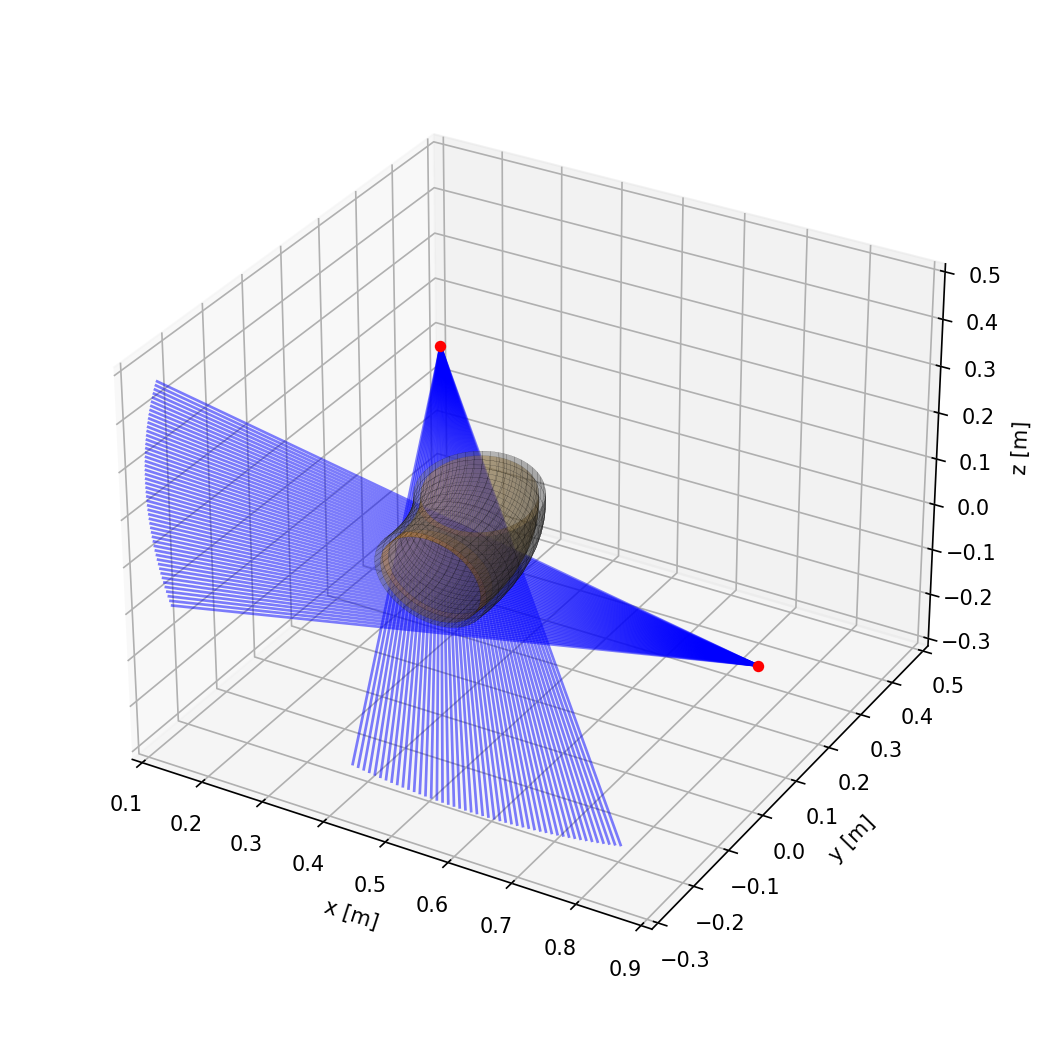

In [29]:
def plot_toroid(elements, R, r):
    u = np.linspace(0, 2*np.pi, elements)
    v = np.linspace(0, 2*np.pi, elements)
    uu, vv = np.meshgrid(u, v)
    xx = (R+r*np.cos(vv))*np.cos(uu)
    yy = (R+r*np.cos(vv))*np.sin(uu)
    zz = r*np.sin(vv)
    coord = [xx, yy, zz]
    return coord

# Create additional toroidal structures
elements = 100
coord_plasma = plot_toroid(elements, 0.4, 0.085)
coord_chamber = plot_toroid(elements, 0.4, 0.095)

# Parameters to plot only a small part of the torus
a = 10; b = 2 

fig = plt.figure(figsize = (7,7),dpi=150)
ax  = fig.add_subplot(projection='3d')

# Plot boundary defined by limiter
ax.plot_surface(coord_plasma[0][:,:a], coord_plasma[1][:,:a], coord_plasma[2][:,:a], antialiased=True, color='orange', edgecolors='k', lw = 0.05, alpha = 0.4)
ax.plot_surface(coord_plasma[0][:,-b:], coord_plasma[1][:,-b:], coord_plasma[2][:,-b:], antialiased=True, color='orange', edgecolors='k', lw = 0.05, alpha = 0.4)
limiter = plt.Circle((0, 0), 0.085, color='tab:orange', fill = False); 

# Plot chamber
ax.plot_surface(coord_chamber[0][:,:a], coord_chamber[1][:,:a], coord_chamber[2][:,:a], antialiased=True, color='grey', edgecolors='k', lw = 0.05, alpha = 0.4)
ax.plot_surface(coord_chamber[0][:,-b:], coord_chamber[1][:,-b:], coord_chamber[2][:,-b:], antialiased=True, color='grey', edgecolors='k', lw = 0.05, alpha = 0.4)
ax.set(xlabel = ('x [m]'), ylabel = ('y [m]'), zlabel = ('z [m]'))
chamber = plt.Circle((0, 0), 0.095, color = 'grey', fill = False);  

sc_unit  = 1  # default is [m]
n_chords = 50 # Plot every 50th chord
# Note that chord with index 0 corresponds to first chord at LFS and top, respectively 
ax.scatter(xchords[0,0],ychords[0,0],zchords[0,0],marker="o",color="red")

ax.scatter(xchords[2000,0],ychords[2000,0],zchords[2000,0],marker="o",color="red")


iteration = 0
for i in np.arange(0, nr, step = 1):
    for j in np.arange(0, nz, step = 1):

        if (iteration % 25)==0: #number after % allows to plot only nth LOS (better visualization)
            ax.plot3D(xchords[iteration,:],ychords[iteration,:],zchords[iteration,:], alpha = 0.5, lw =1.3,color='blue')
        
        iteration = iteration +1

# Clean up
del iteration, i, j     
# Set axes
ax.axes.set_xlim3d(left=0.1, right=0.9) 
ax.axes.set_ylim3d(bottom=-0.3, top=0.5) 
ax.axes.set_zlim3d(bottom=-0.3, top=0.5) 


edge = 0.2
plt.tight_layout(pad=3)